In [1]:
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib.colors import LogNorm

import os
from collections import namedtuple
import sys
sys.path.append('..')

from tqdm import tqdm
import torch

In [2]:
ht = pd.read_csv("../data/raw/hit_info_v2_physics.0007.00930.HLT5.f00000.csv.gz")

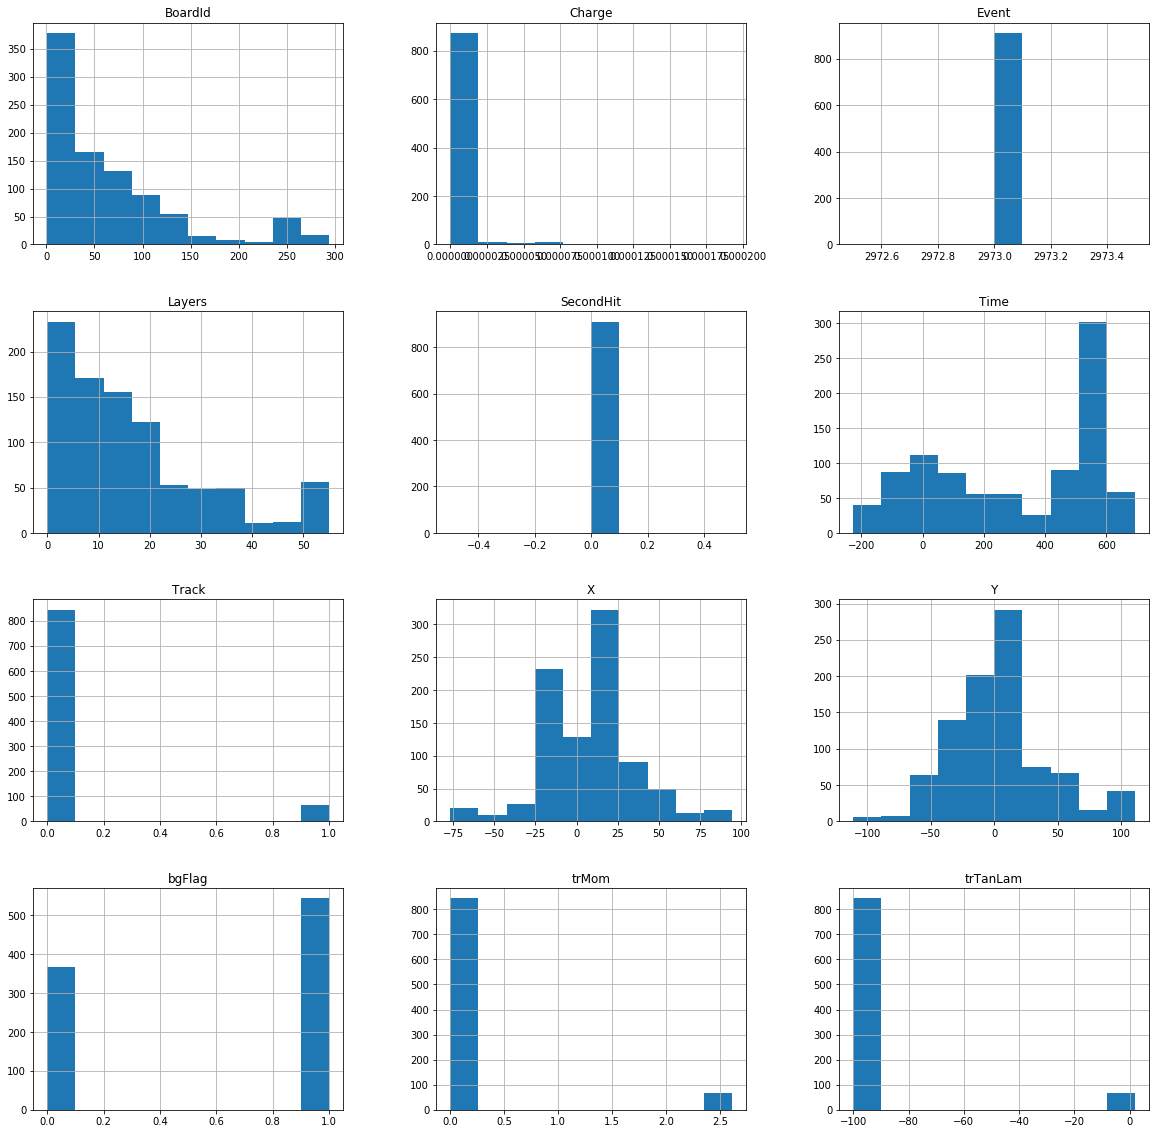

In [3]:
ht[ht['Event'] == 2973].hist(figsize=(20, 20))
plt.show()

In [4]:
ht.columns

Index(['Event', 'Layers', 'X', 'Y', 'Time', 'Charge', 'Track', 'BoardId',
       'SecondHit', 'bgFlag', 'trTanLam', 'trMom'],
      dtype='object')

In [5]:
reco_columns = ['X', 'Y', 'Time', 'Charge', 'Track', 'BoardId']
condition_column = ['SecondHit', 'bgFlag']

class PointsDataset(torch.utils.data.Dataset):
    def __init__(self, pd_table, cloud_size=300):
        self.table = pd_table
        self.events = np.unique(pd_table['Event'])
        self.cloud_size = cloud_size
        
    def __len__(self):
        return len(self.events)
    
    def __getitem__(self, ind):
        points = self.table[self.table["Event"] == self.events[ind]][reco_columns]
        return points.sample(self.cloud_size, replace=True).values.astype(np.float32)

In [6]:
events_dataset = PointsDataset(ht, 800)
train_loader = torch.utils.data.DataLoader(
    events_dataset, batch_size=32,
    drop_last=True, shuffle=True, num_workers=8
)

In [7]:
# !cd ../modules/ && git clone https://github.com/stevenygd/PointFlow.git
# !cd ../modules/PointFlow/ && ./install.sh

# !fileId=1G0rf-6HSHoTll6aH7voh-dXj6hCRhSAQ
# !fileName=ShapeNetCore.v2.PC15k.zip

In [8]:
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1s2NA1unoLScx0GYcZfQ7ot3XkwoH_0l6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1s2NA1unoLScx0GYcZfQ7ot3XkwoH_0l6" -O ShapeNetCore.v2.PC15k.zip && rm -rf /tmp/cookies.txt
# !mv ShapeNetCore.v2.PC15k.zip ../data/ 
# !cd ../data/ && unzip ShapeNetCore.v2.PC15k.zip


In [9]:
sys.path.append('../modules/PointFlow/')

from modules.PointFlow.models.networks import PointFlow

In [10]:
import torch

In [11]:
from collections import namedtuple
Args = namedtuple('flow_args',
                  "input_dim, dims, latent_dims, \
                  num_blocks, latent_num_blocks, layer_type, time_length \
                  train_T, nonlinearity, use_adjoint, solver, atol, rtol, \
                  batch_norm, sync_bn, bn_lag, use_latent_flow, \
                  use_deterministic_encoder, zdim, optimizer, \
                  batch_size, lr, beta1, beta2, momentum, \
                  weight_decay, epochs, seed, recon_weight, \
                  prior_weight, entropy_weight, scheduler, exp_decay, \
                  exp_decay_freq, dataset_type, cates, data_dir, \
                  mn40_data_dir, mn10_data_dir, dataset_scale, \
                  random_rotate, normalize_per_shape, normalize_std_per_axis, tr_max_sample_points \
                  te_max_sample_points, num_workers, log_name, viz_freq, val_freq, log_freq, \
                  save_freq, no_validation, save_val_results, \
                  eval_classification, no_eval_sampling, max_validate_shapes, \
                  resume_checkpoint, resume_optimizer, resume_non_strict, \
                  resume_dataset_mean, resume_dataset_std, world_size, dist_url, \
                  dist_backend, distributed, rank, gpu, evaluate_recon, \
                  num_sample_shapes, num_sample_points")
# random_rotate, normalize_per_shape, normalize_std_per_axis, use_latent_flow, use_deterministic_encoder was None

args = Args(
    input_dim=len(reco_columns), dims='256', latent_dims='256', num_blocks=1, latent_num_blocks=1,
    layer_type="concatsquash", time_length=0.5, train_T=True,
    nonlinearity="tanh", use_adjoint=True, solver='dopri5', 
    atol=1e-5, rtol=1e-5, batch_norm=True, sync_bn=False, bn_lag=0, 

    use_latent_flow=True, use_deterministic_encoder=False, zdim=128,
    optimizer='adam', batch_size=50, lr=1e-3, beta1=0.9, beta2=0.999,
    momentum=0.9, weight_decay=0., epochs=100, seed=None, 
    recon_weight=1., prior_weight=1., entropy_weight=1., 
    scheduler='linear', exp_decay=1., exp_decay_freq=1, 

    dataset_type="shapenet15k", cates=["airplane"], 
    data_dir="../data/ShapeNetCore.v2.PC15k", mn40_data_dir="../data/ModelNet40.PC15k",
    mn10_data_dir="../data/ModelNet10.PC15k", dataset_scale=1., 
    random_rotate=False, normalize_per_shape=False, normalize_std_per_axis=False, 
    tr_max_sample_points=2048, te_max_sample_points=2048, num_workers=8, 

    log_name=None, viz_freq=10, val_freq=10, log_freq=10, save_freq=10, 

    no_validation=None, save_val_results=None, eval_classification=None, 
    no_eval_sampling=None, max_validate_shapes=None, 

    resume_checkpoint=None, resume_optimizer=None, 
    resume_non_strict=None, resume_dataset_mean=None, resume_dataset_std=None,

    world_size=1, dist_url='tcp://127.0.0.1:9991', 
    dist_backend='nccl', distributed=None, rank=0, gpu=1,

    evaluate_recon=False, num_sample_shapes=10, num_sample_points=2048
)

NONLINEARITIES = ["tanh", "relu", "softplus", "elu", "swish", "square", "identity"]
SOLVERS = ["dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams']
LAYERS = ["ignore", "concat", "concat_v2", "squash", "concatsquash", "scale", "concatscale"]

In [12]:
# os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [13]:
# args
# torch.cuda.set_device(args.gpu)

model = PointFlow(args)
model.cuda(args.gpu)

Number of trainable parameters of Point CNF: 71217
Number of trainable parameters of Latent CNF: 67585


PointFlow(
  (encoder): Encoder(
    (conv1): Conv1d(6, 128, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
    (conv4): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1_m): Linear(in_features=512, out_features=256, bias=True)
    (fc2_m): Linear(in_features=256, out_features=128, bias=True)
    (fc3_m): Linear(in_features=128, out_features=128, bias=True)
    (fc_bn1_m): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_bn2_m): BatchNorm1d(128, eps=1e-05, momentum=0.1, affi

In [14]:
start_epoch = 0
optimizer = model.make_optimizer(args)


In [15]:
# from datasets import get_datasets, init_np_seed

# tr_dataset, te_dataset = get_datasets(args)
# if args.distributed:
#     train_sampler = torch.utils.data.distributed.DistributedSampler(tr_dataset)
# else:
#     train_sampler = None

In [16]:
# train_loader = torch.utils.data.DataLoader(
#     dataset=tr_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
#     num_workers=0, pin_memory=True, sampler=train_sampler, drop_last=True,
#     worker_init_fn=init_np_seed)
# test_loader = torch.utils.data.DataLoader(
#     dataset=te_dataset, batch_size=args.batch_size, shuffle=False,
#     num_workers=0, pin_memory=True, drop_last=False,
#     worker_init_fn=init_np_seed)


In [17]:
from torch import optim

# initialize the learning rate scheduler
if args.scheduler == 'exponential':
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, args.exp_decay)
elif args.scheduler == 'step':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.epochs // 2, gamma=0.1)
elif args.scheduler == 'linear':
    def lambda_rule(ep):
        lr_l = 1.0 - max(0, ep - 0.5 * args.epochs) / float(0.5 * args.epochs)
        return lr_l
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
else:
    assert 0, "args.schedulers should be either 'exponential' or 'linear'"



In [18]:
from utils import AverageValueMeter, visualize_point_clouds

entropy_avg_meter = AverageValueMeter()
latent_nats_avg_meter = AverageValueMeter()
point_nats_avg_meter = AverageValueMeter()

writer = None

In [19]:
import time

start_time = time.time()

In [20]:
for epoch in range(start_epoch, args.epochs):
    # adjust the learning rate
    if (epoch + 1) % args.exp_decay_freq == 0:
        scheduler.step(epoch=epoch)
        # log scheduler.get_lr()[0]

    # train for one epoch
    for bidx, tr_batch in enumerate(train_loader):
        step = bidx + len(train_loader) * epoch
        model.train()
        # random rotate?
        inputs = tr_batch.cuda(args.gpu, non_blocking=True)
        out = model(inputs, optimizer, step, writer)
        entropy, prior_nats, recon_nats = out['entropy'], out['prior_nats'], out['recon_nats']
        entropy_avg_meter.update(entropy)
        point_nats_avg_meter.update(recon_nats)
        latent_nats_avg_meter.update(prior_nats)
        
        if step % args.log_freq == 0:
            duration = time.time() - start_time
            start_time = time.time()
            print("[Rank %d] Epoch %d Batch [%2d/%2d] Time [%3.2fs] Entropy %2.5f LatentNats %2.5f PointNats %2.5f"
                  % (args.rank, epoch, bidx, len(train_loader), duration, entropy_avg_meter.avg,
                     latent_nats_avg_meter.avg, point_nats_avg_meter.avg))

#     # evaluate on the validation set
#     if not args.no_validation and (epoch + 1) % args.val_freq == 0:
#         from utils import validate
#         validate(test_loader, model, epoch, writer, save_dir, args, clf_loaders=clf_loaders)


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[Rank 0] Epoch 0 Batch [ 0/368] Time [2.34s] Entropy 184.24469 LatentNats 118.29681 PointNats 9138.01367
[Rank 0] Epoch 0 Batch [10/368] Time [8.16s] Entropy 183.85573 LatentNats 118.23979 PointNats 842.85211
[Rank 0] Epoch 0 Batch [20/368] Time [7.52s] Entropy 183.72168 LatentNats 118.23805 PointNats 447.77048
[Rank 0] Epoch 0 Batch [30/368] Time [7.50s] Entropy 183.60185 LatentNats 118.23457 PointNats 307.42502
[Rank 0] Epoch 0 Batch [40/368] Time [7.67s] Entropy 183.41161 LatentNats 118.23101 PointNats 235.40765
[Rank 0] Epoch 0 Batch [50/368] Time [7.56s] Entropy 183.06957 LatentNats 118.22696 PointNats 191.52115
[Rank 0] Epoch 0 Batch [60/368] Time [8.01s] Entropy 182.47730 LatentNats 118.22111 PointNats 161.93477
[Rank 0] Epoch 0 Batch [70/368] Time [8.69s] Entropy 181.56148 LatentNats 118.21242 PointNats 140.61719
[Rank 0] Epoch 0 Batch [80/368] Time [10.29s] Entropy 180.25834 LatentNats 118.20254 PointNats 124.51892
[Rank 0] Epoch 0 Batch [90/368] Time [11.40s] Entropy 178.5813

[Rank 0] Epoch 2 Batch [54/368] Time [18.18s] Entropy -16.58042 LatentNats 116.80094 PointNats 20.91699
[Rank 0] Epoch 2 Batch [64/368] Time [16.57s] Entropy -18.47826 LatentNats 116.78911 PointNats 20.76825
[Rank 0] Epoch 2 Batch [74/368] Time [17.11s] Entropy -20.32705 LatentNats 116.77692 PointNats 20.62148
[Rank 0] Epoch 2 Batch [84/368] Time [17.84s] Entropy -22.13156 LatentNats 116.76450 PointNats 20.47811
[Rank 0] Epoch 2 Batch [94/368] Time [17.28s] Entropy -23.91686 LatentNats 116.75190 PointNats 20.33720
[Rank 0] Epoch 2 Batch [104/368] Time [17.20s] Entropy -25.67352 LatentNats 116.73940 PointNats 20.19967
[Rank 0] Epoch 2 Batch [114/368] Time [17.20s] Entropy -27.40242 LatentNats 116.72721 PointNats 20.06552
[Rank 0] Epoch 2 Batch [124/368] Time [16.87s] Entropy -29.06242 LatentNats 116.71519 PointNats 19.93468
[Rank 0] Epoch 2 Batch [134/368] Time [17.18s] Entropy -30.73713 LatentNats 116.70306 PointNats 19.80650
[Rank 0] Epoch 2 Batch [144/368] Time [17.21s] Entropy -32.3

[Rank 0] Epoch 4 Batch [108/368] Time [16.44s] Entropy -112.00644 LatentNats 116.13067 PointNats 14.84711
[Rank 0] Epoch 4 Batch [118/368] Time [16.24s] Entropy -112.81985 LatentNats 116.12518 PointNats 14.80996
[Rank 0] Epoch 4 Batch [128/368] Time [17.31s] Entropy -113.64173 LatentNats 116.11948 PointNats 14.77208
[Rank 0] Epoch 4 Batch [138/368] Time [17.54s] Entropy -114.47489 LatentNats 116.11393 PointNats 14.73407
[Rank 0] Epoch 4 Batch [148/368] Time [17.48s] Entropy -115.28675 LatentNats 116.10840 PointNats 14.69674
[Rank 0] Epoch 4 Batch [158/368] Time [16.82s] Entropy -116.07639 LatentNats 116.10300 PointNats 14.66022
[Rank 0] Epoch 4 Batch [168/368] Time [16.80s] Entropy -116.85446 LatentNats 116.09758 PointNats 14.62419
[Rank 0] Epoch 4 Batch [178/368] Time [17.44s] Entropy -117.61299 LatentNats 116.09220 PointNats 14.58818
[Rank 0] Epoch 4 Batch [188/368] Time [17.28s] Entropy -118.36490 LatentNats 116.08665 PointNats 14.55222
[Rank 0] Epoch 4 Batch [198/368] Time [17.53s]

[Rank 0] Epoch 6 Batch [152/368] Time [16.92s] Entropy -158.45877 LatentNats 115.80216 PointNats 12.82592
[Rank 0] Epoch 6 Batch [162/368] Time [17.31s] Entropy -158.96718 LatentNats 115.79888 PointNats 12.80825
[Rank 0] Epoch 6 Batch [172/368] Time [16.96s] Entropy -159.50615 LatentNats 115.79527 PointNats 12.79065
[Rank 0] Epoch 6 Batch [182/368] Time [17.54s] Entropy -160.06422 LatentNats 115.79135 PointNats 12.77330
[Rank 0] Epoch 6 Batch [192/368] Time [17.15s] Entropy -160.62470 LatentNats 115.78750 PointNats 12.75606
[Rank 0] Epoch 6 Batch [202/368] Time [17.17s] Entropy -161.16969 LatentNats 115.78370 PointNats 12.73873
[Rank 0] Epoch 6 Batch [212/368] Time [17.03s] Entropy -161.71249 LatentNats 115.77982 PointNats 12.72259
[Rank 0] Epoch 6 Batch [222/368] Time [16.78s] Entropy -162.24223 LatentNats 115.77624 PointNats 12.70669
[Rank 0] Epoch 6 Batch [232/368] Time [16.03s] Entropy -162.74983 LatentNats 115.77271 PointNats 12.69061
[Rank 0] Epoch 6 Batch [242/368] Time [16.67s]

[Rank 0] Epoch 8 Batch [196/368] Time [17.82s] Entropy -190.30718 LatentNats 115.56208 PointNats 11.79342
[Rank 0] Epoch 8 Batch [206/368] Time [17.56s] Entropy -190.65015 LatentNats 115.55921 PointNats 11.78306
[Rank 0] Epoch 8 Batch [216/368] Time [17.84s] Entropy -190.99783 LatentNats 115.55644 PointNats 11.77291
[Rank 0] Epoch 8 Batch [226/368] Time [17.80s] Entropy -191.35787 LatentNats 115.55347 PointNats 11.76280
[Rank 0] Epoch 8 Batch [236/368] Time [17.85s] Entropy -191.70201 LatentNats 115.55064 PointNats 11.75260
[Rank 0] Epoch 8 Batch [246/368] Time [17.89s] Entropy -192.04671 LatentNats 115.54770 PointNats 11.74267
[Rank 0] Epoch 8 Batch [256/368] Time [17.21s] Entropy -192.39925 LatentNats 115.54506 PointNats 11.73404
[Rank 0] Epoch 8 Batch [266/368] Time [15.70s] Entropy -192.75538 LatentNats 115.54283 PointNats 11.72513
[Rank 0] Epoch 8 Batch [276/368] Time [15.77s] Entropy -193.06497 LatentNats 115.54062 PointNats 11.71605
[Rank 0] Epoch 8 Batch [286/368] Time [16.46s]

[Rank 0] Epoch 10 Batch [240/368] Time [17.46s] Entropy -214.61656 LatentNats 115.36929 PointNats 11.16137
[Rank 0] Epoch 10 Batch [250/368] Time [17.80s] Entropy -214.89735 LatentNats 115.36693 PointNats 11.15486
[Rank 0] Epoch 10 Batch [260/368] Time [17.51s] Entropy -215.17515 LatentNats 115.36455 PointNats 11.14819
[Rank 0] Epoch 10 Batch [270/368] Time [18.35s] Entropy -215.46032 LatentNats 115.36214 PointNats 11.14152
[Rank 0] Epoch 10 Batch [280/368] Time [17.75s] Entropy -215.72916 LatentNats 115.35985 PointNats 11.13478
[Rank 0] Epoch 10 Batch [290/368] Time [18.22s] Entropy -216.00571 LatentNats 115.35746 PointNats 11.12809
[Rank 0] Epoch 10 Batch [300/368] Time [18.03s] Entropy -216.29971 LatentNats 115.35526 PointNats 11.12208
[Rank 0] Epoch 10 Batch [310/368] Time [17.86s] Entropy -216.58730 LatentNats 115.35336 PointNats 11.11590
[Rank 0] Epoch 10 Batch [320/368] Time [17.95s] Entropy -216.85896 LatentNats 115.35127 PointNats 11.10954
[Rank 0] Epoch 10 Batch [330/368] Tim

[Rank 0] Epoch 12 Batch [274/368] Time [19.00s] Entropy -235.29586 LatentNats 115.20474 PointNats 10.73331
[Rank 0] Epoch 12 Batch [284/368] Time [19.22s] Entropy -235.56295 LatentNats 115.20258 PointNats 10.72844
[Rank 0] Epoch 12 Batch [294/368] Time [19.18s] Entropy -235.82024 LatentNats 115.20043 PointNats 10.72380
[Rank 0] Epoch 12 Batch [304/368] Time [19.16s] Entropy -236.08442 LatentNats 115.19834 PointNats 10.71900
[Rank 0] Epoch 12 Batch [314/368] Time [19.09s] Entropy -236.34616 LatentNats 115.19620 PointNats 10.71414
[Rank 0] Epoch 12 Batch [324/368] Time [18.81s] Entropy -236.60154 LatentNats 115.19407 PointNats 10.70943
[Rank 0] Epoch 12 Batch [334/368] Time [19.16s] Entropy -236.85573 LatentNats 115.19209 PointNats 10.70490
[Rank 0] Epoch 12 Batch [344/368] Time [18.93s] Entropy -237.10916 LatentNats 115.19017 PointNats 10.70013
[Rank 0] Epoch 12 Batch [354/368] Time [18.89s] Entropy -237.36671 LatentNats 115.18809 PointNats 10.69546
[Rank 0] Epoch 12 Batch [364/368] Tim

[Rank 0] Epoch 14 Batch [308/368] Time [20.13s] Entropy -254.22376 LatentNats 115.05003 PointNats 10.40862
[Rank 0] Epoch 14 Batch [318/368] Time [20.38s] Entropy -254.45034 LatentNats 115.04807 PointNats 10.40480
[Rank 0] Epoch 14 Batch [328/368] Time [20.40s] Entropy -254.67540 LatentNats 115.04608 PointNats 10.40099
[Rank 0] Epoch 14 Batch [338/368] Time [20.04s] Entropy -254.91821 LatentNats 115.04409 PointNats 10.39726
[Rank 0] Epoch 14 Batch [348/368] Time [20.31s] Entropy -255.16743 LatentNats 115.04216 PointNats 10.39365
[Rank 0] Epoch 14 Batch [358/368] Time [20.31s] Entropy -255.41955 LatentNats 115.04011 PointNats 10.39029
[Rank 0] Epoch 15 Batch [ 0/368] Time [21.33s] Entropy -255.67832 LatentNats 115.03829 PointNats 10.38692
[Rank 0] Epoch 15 Batch [10/368] Time [20.00s] Entropy -255.92559 LatentNats 115.03643 PointNats 10.38344
[Rank 0] Epoch 15 Batch [20/368] Time [20.31s] Entropy -256.16060 LatentNats 115.03457 PointNats 10.37999
[Rank 0] Epoch 15 Batch [30/368] Time [2

[Rank 0] Epoch 16 Batch [342/368] Time [20.65s] Entropy -271.73244 LatentNats 114.90404 PointNats 10.15932
[Rank 0] Epoch 16 Batch [352/368] Time [21.24s] Entropy -271.93854 LatentNats 114.90218 PointNats 10.15649
[Rank 0] Epoch 16 Batch [362/368] Time [21.32s] Entropy -272.14852 LatentNats 114.90032 PointNats 10.15348
[Rank 0] Epoch 17 Batch [ 4/368] Time [22.11s] Entropy -272.36001 LatentNats 114.89843 PointNats 10.15052
[Rank 0] Epoch 17 Batch [14/368] Time [21.03s] Entropy -272.57228 LatentNats 114.89652 PointNats 10.14752
[Rank 0] Epoch 17 Batch [24/368] Time [21.42s] Entropy -272.78404 LatentNats 114.89462 PointNats 10.14481
[Rank 0] Epoch 17 Batch [34/368] Time [21.22s] Entropy -273.00183 LatentNats 114.89272 PointNats 10.14194
[Rank 0] Epoch 17 Batch [44/368] Time [21.13s] Entropy -273.21811 LatentNats 114.89088 PointNats 10.13906
[Rank 0] Epoch 17 Batch [54/368] Time [21.25s] Entropy -273.43954 LatentNats 114.88898 PointNats 10.13635
[Rank 0] Epoch 17 Batch [64/368] Time [20.9

[Rank 0] Epoch 19 Batch [ 8/368] Time [22.46s] Entropy -289.25548 LatentNats 114.75115 PointNats 9.95974
[Rank 0] Epoch 19 Batch [18/368] Time [22.11s] Entropy -289.48719 LatentNats 114.74907 PointNats 9.95734
[Rank 0] Epoch 19 Batch [28/368] Time [21.77s] Entropy -289.71804 LatentNats 114.74706 PointNats 9.95491
[Rank 0] Epoch 19 Batch [38/368] Time [22.96s] Entropy -289.95032 LatentNats 114.74502 PointNats 9.95247
[Rank 0] Epoch 19 Batch [48/368] Time [22.84s] Entropy -290.18575 LatentNats 114.74299 PointNats 9.95013
[Rank 0] Epoch 19 Batch [58/368] Time [22.96s] Entropy -290.42033 LatentNats 114.74092 PointNats 9.94773
[Rank 0] Epoch 19 Batch [68/368] Time [22.22s] Entropy -290.65759 LatentNats 114.73885 PointNats 9.94565
[Rank 0] Epoch 19 Batch [78/368] Time [21.26s] Entropy -290.89453 LatentNats 114.73679 PointNats 9.94356
[Rank 0] Epoch 19 Batch [88/368] Time [21.05s] Entropy -291.12598 LatentNats 114.73474 PointNats 9.94150
[Rank 0] Epoch 19 Batch [98/368] Time [20.99s] Entropy 

[Rank 0] Epoch 21 Batch [52/368] Time [22.34s] Entropy -306.23129 LatentNats 114.60175 PointNats 9.79653
[Rank 0] Epoch 21 Batch [62/368] Time [22.20s] Entropy -306.45092 LatentNats 114.59982 PointNats 9.79466
[Rank 0] Epoch 21 Batch [72/368] Time [22.20s] Entropy -306.66925 LatentNats 114.59786 PointNats 9.79286
[Rank 0] Epoch 21 Batch [82/368] Time [22.91s] Entropy -306.88381 LatentNats 114.59594 PointNats 9.79096
[Rank 0] Epoch 21 Batch [92/368] Time [22.49s] Entropy -307.09615 LatentNats 114.59402 PointNats 9.78913
[Rank 0] Epoch 21 Batch [102/368] Time [22.30s] Entropy -307.31382 LatentNats 114.59209 PointNats 9.78725
[Rank 0] Epoch 21 Batch [112/368] Time [22.22s] Entropy -307.52551 LatentNats 114.59016 PointNats 9.78533
[Rank 0] Epoch 21 Batch [122/368] Time [23.24s] Entropy -307.73643 LatentNats 114.58825 PointNats 9.78339
[Rank 0] Epoch 21 Batch [132/368] Time [23.37s] Entropy -307.94682 LatentNats 114.58634 PointNats 9.78143
[Rank 0] Epoch 21 Batch [142/368] Time [22.74s] Ent

[Rank 0] Epoch 23 Batch [96/368] Time [22.59s] Entropy -322.12848 LatentNats 114.46033 PointNats 9.66130
[Rank 0] Epoch 23 Batch [106/368] Time [22.41s] Entropy -322.31802 LatentNats 114.45863 PointNats 9.65970
[Rank 0] Epoch 23 Batch [116/368] Time [22.65s] Entropy -322.50729 LatentNats 114.45693 PointNats 9.65806
[Rank 0] Epoch 23 Batch [126/368] Time [22.69s] Entropy -322.69921 LatentNats 114.45522 PointNats 9.65649
[Rank 0] Epoch 23 Batch [136/368] Time [22.59s] Entropy -322.89020 LatentNats 114.45352 PointNats 9.65483
[Rank 0] Epoch 23 Batch [146/368] Time [22.88s] Entropy -323.07890 LatentNats 114.45215 PointNats 9.65316
[Rank 0] Epoch 23 Batch [156/368] Time [22.75s] Entropy -323.26798 LatentNats 114.45050 PointNats 9.65156
[Rank 0] Epoch 23 Batch [166/368] Time [23.05s] Entropy -323.44903 LatentNats 114.44890 PointNats 9.65016
[Rank 0] Epoch 23 Batch [176/368] Time [22.82s] Entropy -323.62556 LatentNats 114.44733 PointNats 9.64874
[Rank 0] Epoch 23 Batch [186/368] Time [22.75s]

[Rank 0] Epoch 25 Batch [190/368] Time [25.28s] Entropy -337.56632 LatentNats 114.32413 PointNats 9.54175
[Rank 0] Epoch 25 Batch [200/368] Time [25.12s] Entropy -337.74170 LatentNats 114.32259 PointNats 9.54041
[Rank 0] Epoch 25 Batch [210/368] Time [26.06s] Entropy -337.91794 LatentNats 114.32103 PointNats 9.53913
[Rank 0] Epoch 25 Batch [220/368] Time [25.25s] Entropy -338.09355 LatentNats 114.31950 PointNats 9.53774
[Rank 0] Epoch 25 Batch [230/368] Time [25.62s] Entropy -338.26964 LatentNats 114.31794 PointNats 9.53640
[Rank 0] Epoch 25 Batch [240/368] Time [25.73s] Entropy -338.45075 LatentNats 114.31632 PointNats 9.53525
[Rank 0] Epoch 25 Batch [250/368] Time [25.20s] Entropy -338.63533 LatentNats 114.31480 PointNats 9.53420
[Rank 0] Epoch 25 Batch [260/368] Time [25.60s] Entropy -338.82159 LatentNats 114.31316 PointNats 9.53296
[Rank 0] Epoch 25 Batch [270/368] Time [25.87s] Entropy -339.00018 LatentNats 114.31160 PointNats 9.53166
[Rank 0] Epoch 25 Batch [280/368] Time [25.58s

[Rank 0] Epoch 27 Batch [274/368] Time [26.91s] Entropy -351.37907 LatentNats 114.20170 PointNats 9.44423
[Rank 0] Epoch 27 Batch [284/368] Time [26.24s] Entropy -351.53895 LatentNats 114.20031 PointNats 9.44308
[Rank 0] Epoch 27 Batch [294/368] Time [26.64s] Entropy -351.69701 LatentNats 114.19891 PointNats 9.44198
[Rank 0] Epoch 27 Batch [304/368] Time [26.88s] Entropy -351.85450 LatentNats 114.19750 PointNats 9.44086
[Rank 0] Epoch 27 Batch [314/368] Time [26.96s] Entropy -352.01084 LatentNats 114.19610 PointNats 9.43977
[Rank 0] Epoch 27 Batch [324/368] Time [26.86s] Entropy -352.16825 LatentNats 114.19470 PointNats 9.43879
[Rank 0] Epoch 27 Batch [334/368] Time [26.90s] Entropy -352.32960 LatentNats 114.19331 PointNats 9.43775
[Rank 0] Epoch 27 Batch [344/368] Time [27.34s] Entropy -352.49125 LatentNats 114.19196 PointNats 9.43665
[Rank 0] Epoch 27 Batch [354/368] Time [27.00s] Entropy -352.65520 LatentNats 114.19054 PointNats 9.43551
[Rank 0] Epoch 27 Batch [364/368] Time [26.75s

[Rank 0] Epoch 29 Batch [358/368] Time [27.90s] Entropy -363.25278 LatentNats 114.09772 PointNats 9.36133
[Rank 0] Epoch 30 Batch [ 0/368] Time [29.04s] Entropy -363.39226 LatentNats 114.09649 PointNats 9.36036
[Rank 0] Epoch 30 Batch [10/368] Time [28.23s] Entropy -363.53284 LatentNats 114.09528 PointNats 9.35939
[Rank 0] Epoch 30 Batch [20/368] Time [28.41s] Entropy -363.67364 LatentNats 114.09405 PointNats 9.35839
[Rank 0] Epoch 30 Batch [30/368] Time [28.25s] Entropy -363.81398 LatentNats 114.09283 PointNats 9.35735
[Rank 0] Epoch 30 Batch [40/368] Time [28.20s] Entropy -363.95547 LatentNats 114.09158 PointNats 9.35637
[Rank 0] Epoch 30 Batch [50/368] Time [28.63s] Entropy -364.09946 LatentNats 114.09034 PointNats 9.35538
[Rank 0] Epoch 30 Batch [60/368] Time [28.41s] Entropy -364.24575 LatentNats 114.08904 PointNats 9.35438
[Rank 0] Epoch 30 Batch [70/368] Time [28.45s] Entropy -364.39311 LatentNats 114.08775 PointNats 9.35346
[Rank 0] Epoch 30 Batch [80/368] Time [28.05s] Entropy

[Rank 0] Epoch 32 Batch [84/368] Time [28.37s] Entropy -375.42073 LatentNats 113.99266 PointNats 9.28691
[Rank 0] Epoch 32 Batch [94/368] Time [28.50s] Entropy -375.55675 LatentNats 113.99149 PointNats 9.28605
[Rank 0] Epoch 32 Batch [104/368] Time [28.33s] Entropy -375.69310 LatentNats 113.99031 PointNats 9.28525
[Rank 0] Epoch 32 Batch [114/368] Time [28.53s] Entropy -375.83160 LatentNats 113.98910 PointNats 9.28445
[Rank 0] Epoch 32 Batch [124/368] Time [28.64s] Entropy -375.96947 LatentNats 113.98791 PointNats 9.28367
[Rank 0] Epoch 32 Batch [134/368] Time [28.51s] Entropy -376.10519 LatentNats 113.98674 PointNats 9.28290
[Rank 0] Epoch 32 Batch [144/368] Time [28.56s] Entropy -376.24153 LatentNats 113.98579 PointNats 9.28205
[Rank 0] Epoch 32 Batch [154/368] Time [28.46s] Entropy -376.37038 LatentNats 113.98467 PointNats 9.28123
[Rank 0] Epoch 32 Batch [164/368] Time [29.01s] Entropy -376.49275 LatentNats 113.98360 PointNats 9.28041
[Rank 0] Epoch 32 Batch [174/368] Time [28.87s] 

[Rank 0] Epoch 34 Batch [128/368] Time [28.64s] Entropy -385.15181 LatentNats 113.90860 PointNats 9.22552
[Rank 0] Epoch 34 Batch [138/368] Time [28.90s] Entropy -385.28068 LatentNats 113.90749 PointNats 9.22478
[Rank 0] Epoch 34 Batch [148/368] Time [28.85s] Entropy -385.40680 LatentNats 113.90639 PointNats 9.22401
[Rank 0] Epoch 34 Batch [158/368] Time [29.86s] Entropy -385.53311 LatentNats 113.90530 PointNats 9.22321
[Rank 0] Epoch 34 Batch [168/368] Time [28.96s] Entropy -385.65950 LatentNats 113.90419 PointNats 9.22251
[Rank 0] Epoch 34 Batch [178/368] Time [29.68s] Entropy -385.78624 LatentNats 113.90315 PointNats 9.22203
[Rank 0] Epoch 34 Batch [188/368] Time [29.31s] Entropy -385.91319 LatentNats 113.90215 PointNats 9.22139
[Rank 0] Epoch 34 Batch [198/368] Time [29.74s] Entropy -386.03920 LatentNats 113.90109 PointNats 9.22067
[Rank 0] Epoch 34 Batch [208/368] Time [28.70s] Entropy -386.16416 LatentNats 113.90001 PointNats 9.21999
[Rank 0] Epoch 34 Batch [218/368] Time [28.94s

[Rank 0] Epoch 36 Batch [172/368] Time [28.88s] Entropy -394.62503 LatentNats 113.82699 PointNats 9.17124
[Rank 0] Epoch 36 Batch [182/368] Time [28.94s] Entropy -394.74351 LatentNats 113.82598 PointNats 9.17054
[Rank 0] Epoch 36 Batch [192/368] Time [29.39s] Entropy -394.86134 LatentNats 113.82497 PointNats 9.16996
[Rank 0] Epoch 36 Batch [202/368] Time [29.36s] Entropy -394.97867 LatentNats 113.82398 PointNats 9.16937
[Rank 0] Epoch 36 Batch [212/368] Time [29.21s] Entropy -395.09526 LatentNats 113.82301 PointNats 9.16873
[Rank 0] Epoch 36 Batch [222/368] Time [29.02s] Entropy -395.21160 LatentNats 113.82201 PointNats 9.16805
[Rank 0] Epoch 36 Batch [232/368] Time [29.22s] Entropy -395.32724 LatentNats 113.82104 PointNats 9.16736
[Rank 0] Epoch 36 Batch [242/368] Time [30.99s] Entropy -395.44274 LatentNats 113.82005 PointNats 9.16673
[Rank 0] Epoch 36 Batch [252/368] Time [30.30s] Entropy -395.55691 LatentNats 113.81907 PointNats 9.16607
[Rank 0] Epoch 36 Batch [262/368] Time [29.58s

KeyboardInterrupt: 

In [21]:
def DrawCDCSuperLayerXY():
    '''Draw boundaries of CDC superlayers'''
    SuperLayerBoundary = [16.8, 25.7, 36.5, 47.6, 58.4, 69.5, 80.2, 91.3, 102.1, 111.1 ]
    ax = plt.gca()
    cols = ["b","r"]
    i = 0
    for r in SuperLayerBoundary:
        circle1 = plt.Circle((0, 0), r, color=cols[i % 2],fill=False)
        ax.add_artist(circle1)
        i += 1
        
def drawEv(x,y,z,cmap=None,norm=None):
    plt.xlim(-120.,120.)
    plt.ylim(-120.,120.)
    DrawCDCSuperLayerXY()
    plt.scatter(x,y, c=z,  cmap=cmap, marker='.', norm=norm)
    plt.colorbar()
    plt.xlabel("X / cm")
    plt.ylabel("Y /cm ")
    
def plot_event(event):
    plt.figure(figsize=(12, 10))
    plt.title(f"Real event")

    X, Y = event[:, 0], event[:, 1]
    
    plt.subplot(221)
    # Board IDs
    drawEv(X, Y, event[:, 5] // 2 % 20, plt.get_cmap('tab20b'))
    plt.title('RO Board // 2')
    
    # Time
    plt.subplot(222)
    drawEv(X, Y, event[:, 2])
    plt.title('Time')
    
    # ADC
    plt.subplot(223)
    drawEv(X, Y, event[:, 3],
           norm=LogNorm()) 
    plt.title('Charge')
    
    # TOT
    plt.subplot(224)
    drawEv(X, Y, event[:, 4], plt.get_cmap('Accent'))
    plt.title('Track')


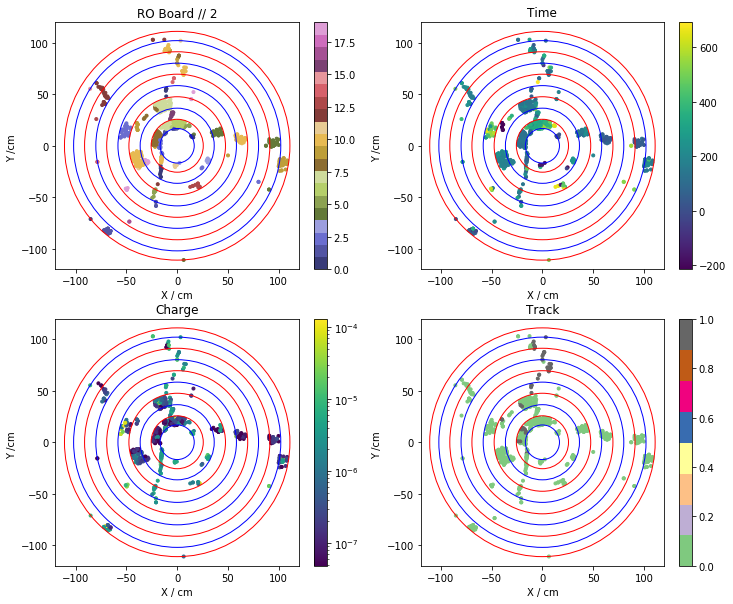

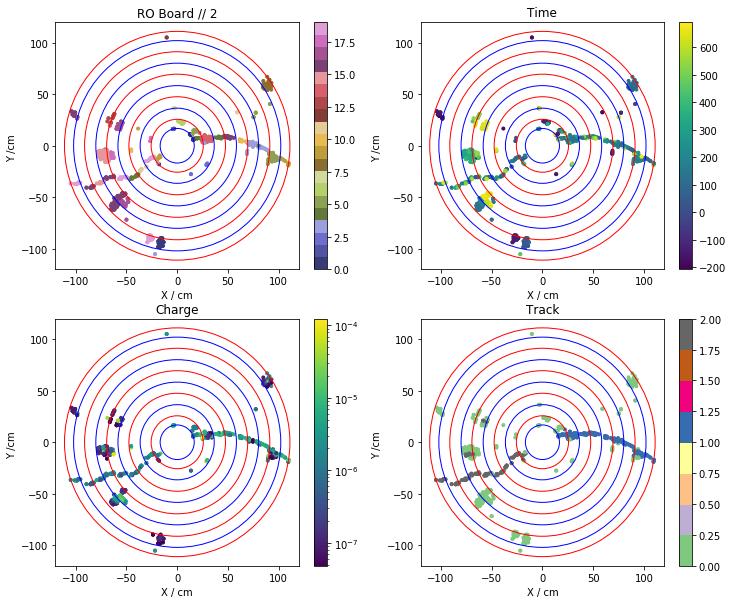

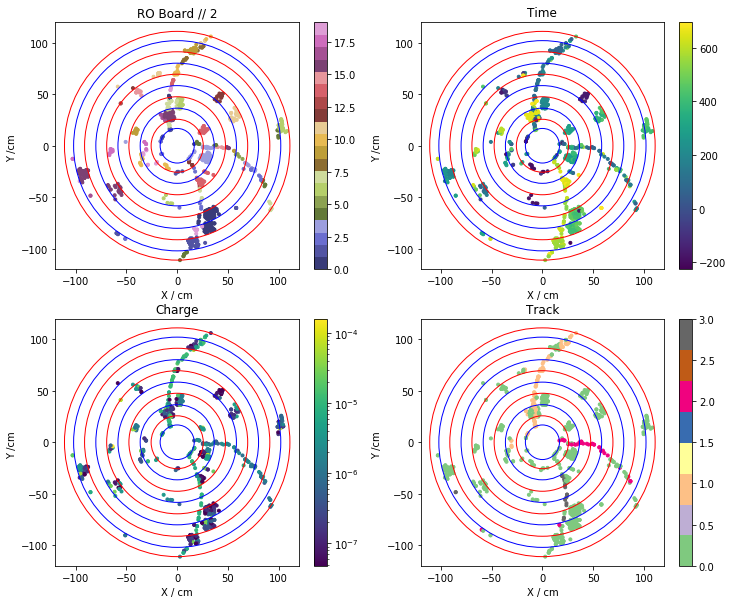

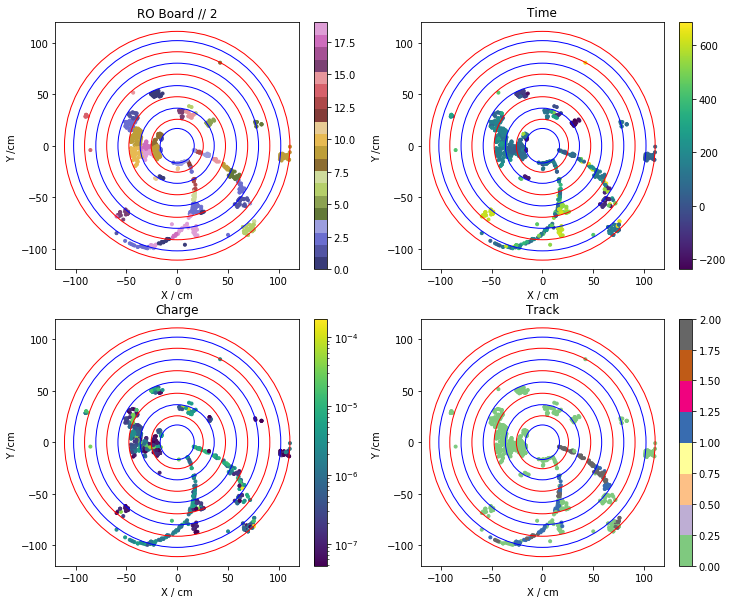

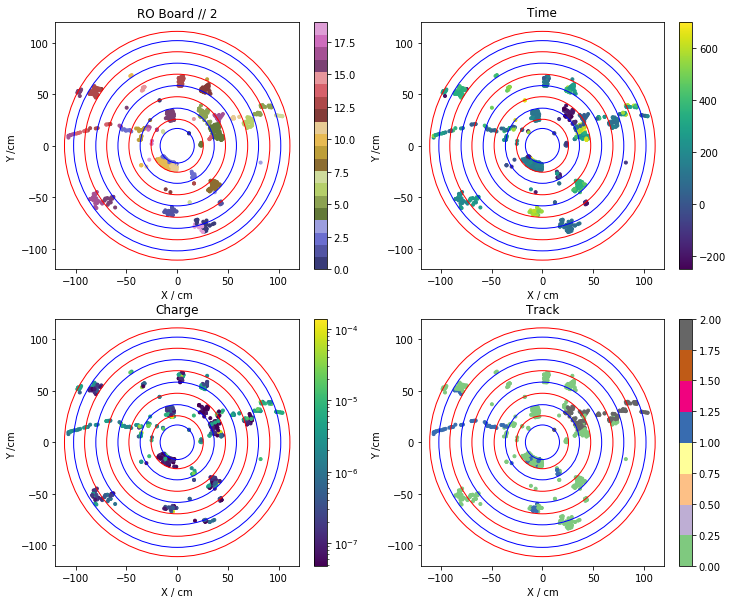

In [22]:
events = inputs.detach().cpu().numpy()
for event in events[:5]:
    plot_event(event)
    plt.show()

In [26]:
model.cpu().eval()
_, samples = model.sample(5, 100)
samples = samples.detach().cpu().numpy()

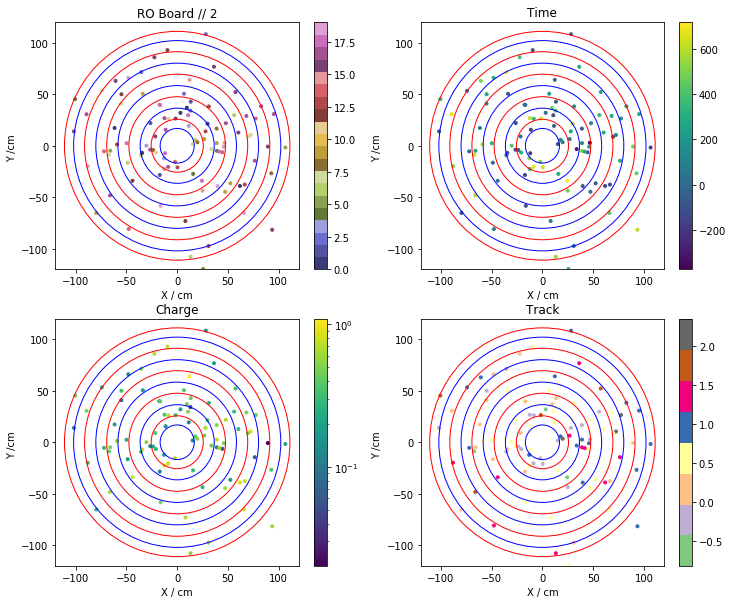

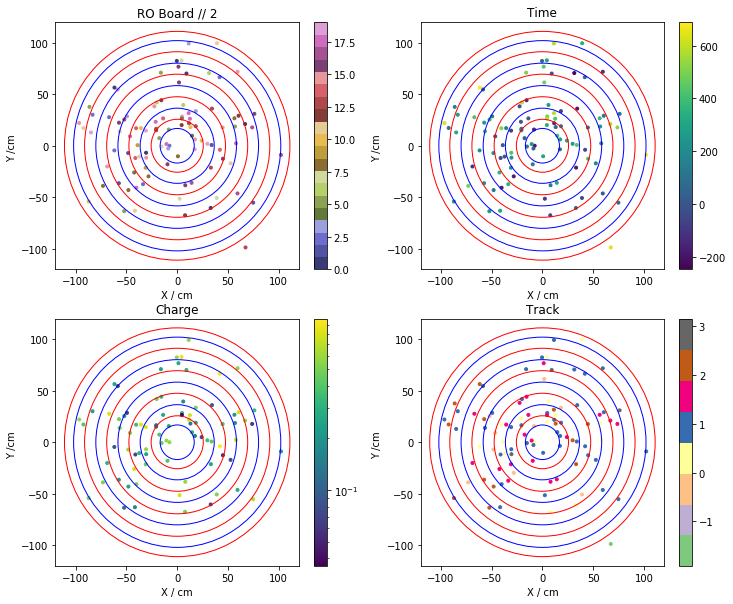

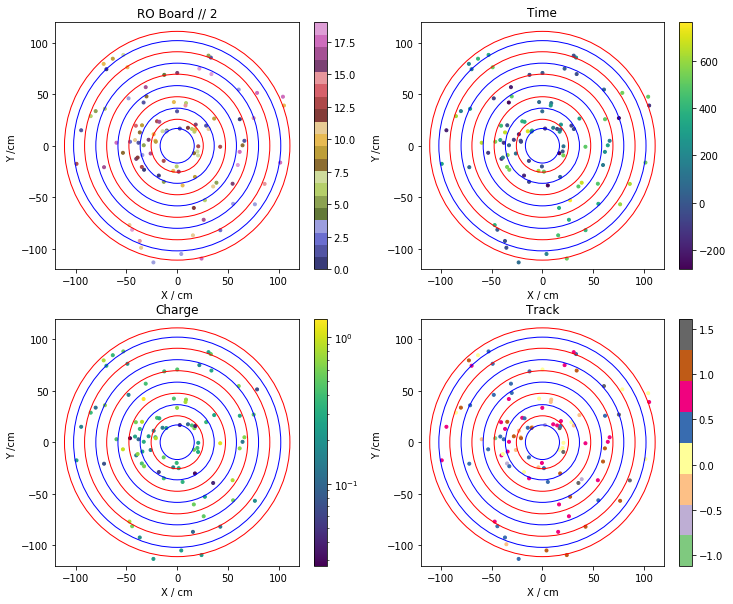

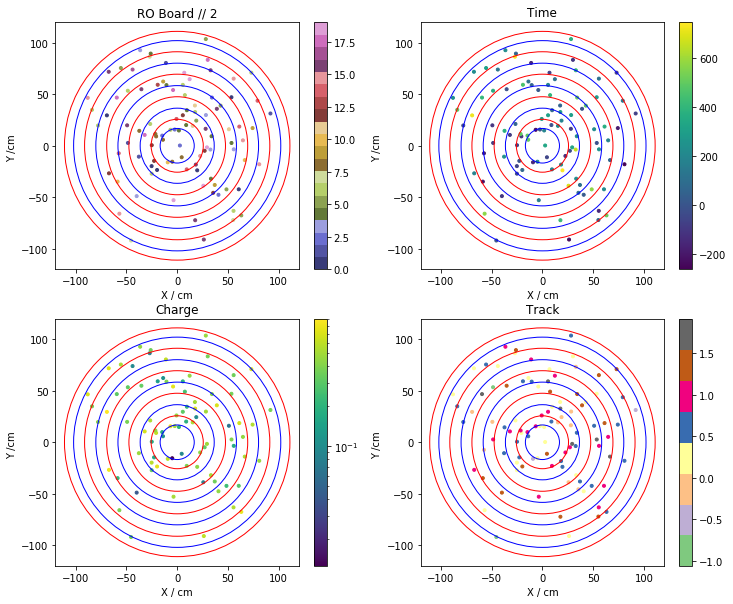

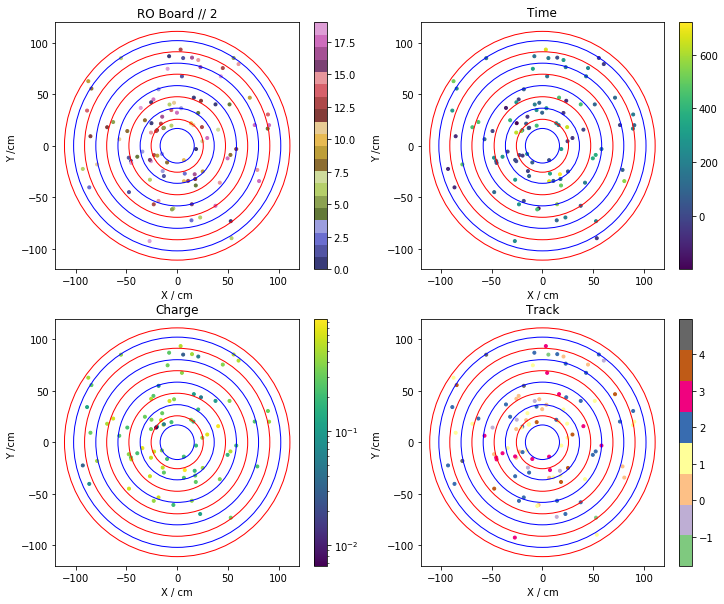

In [27]:
for event in samples[:5]:
    plot_event(event)
    plt.show()

In [ ]:
import scipy
import scipy.misc
save_dir = './'

# reconstructions
model.eval()
model.cpu()
samples = model.reconstruct(inputs.cpu())
results = []
for idx in range(min(10, inputs.size(0))):
    res = visualize_point_clouds(samples[idx], inputs[idx], idx,
                                 pert_order=train_loader.dataset.display_axis_order)
    results.append(res)
res = np.concatenate(results, axis=1)

In [ ]:
# !pip install imageio
import imageio

os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)

In [ ]:
imageio.imwrite(os.path.join(save_dir, 'images', 'tr_vis_conditioned_epoch%d-gpu%s.png' % (epoch, args.gpu)),
                res.transpose((1, 2, 0)))
if writer is not None:
    writer.add_image('tr_vis/conditioned', torch.as_tensor(res), epoch)


In [ ]:
# samples
num_samples = min(10, inputs.size(0))
num_points = inputs.size(1)
_, samples = model.sample(num_samples, num_points)
results = []
for idx in range(num_samples):
    res = visualize_point_clouds(samples[idx], inputs[idx], idx,
                                 pert_order=train_loader.dataset.display_axis_order)
    results.append(res)
res = np.concatenate(results, axis=1)


In [ ]:
imageio.imwrite(os.path.join(save_dir, 'images', 'tr_vis_conditioned_epoch%d-gpu%s.png' % (epoch, args.gpu)),
                res.transpose((1, 2, 0)))
if writer is not None:
    writer.add_image('tr_vis/sampled', torch.as_tensor(res), epoch)


In [ ]:
res.shape

In [ ]:
1